# Text Classification: sentiment analysis.

### Data

The dataset we will use of this problem is known as the Stanford Sentiment Treebank. Movie reviews with one sentence per review:
* `sst.bin.*` with binary labels: negative or positive
* `sst.fine.*` with fine-grained labels (very negative, negative, neutral, positive, very positive),

In [1]:
import keras
import numpy as np
from matplotlib import pyplot as plt

/home/hov/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
with open("data/sst.bin.train", "r") as f:
    train = [(int(x.split()[0]), x.split()[1:]) for x in f.readlines()]
with open("data/sst.bin.val", "r") as f:
    val = [(int(x.split()[0]), x.split()[1:]) for x in f.readlines()]
with open("data/sst.bin.test", "r") as f:
    test = [(x.split()[1:]) for x in f.readlines()]
print("Train:     ", len(train), "  Mean sentence length:", np.mean([len(x[1]) for x in train]).round(2))
print("Validation:", len(val))
print("Test:      ", len(test))

Train:      6920   Mean sentence length: 19.3
Validation: 872
Test:       1821


In [3]:
from collections import Counter, defaultdict
import itertools


In [4]:
# calculate word frequencies
word_frequencies = Counter(itertools.chain(
    *((word for word in sample[1]) for sample in train)
))

Vocabulary size: 14828


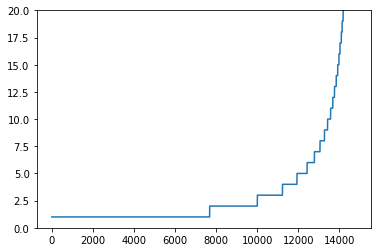

In [6]:
print("Vocabulary size:", len(word_frequencies))

plt.plot([x[1] for x in word_frequencies.most_common()[::-1]])
plt.ylim(0, 20);

In [7]:
# indexing words

PAD = 0 # padding
UNK = 1 # unknown word
vocab = dict()

word_index = 2
for w, c in word_frequencies.items():
    if c > 3:
        vocab[w] = word_index
        word_index += 1

len(vocab), word_index

(3592, 3594)

In [9]:
# change words with indices

train_X = [[vocab.get(x, UNK) for x in sample[1]]
                    for sample in train]
train_y = [sample[0] for sample in train]

max_len = np.sort([len(x) for x in train_X])

val_X = [[vocab.get(x, UNK) for x in sample[1]]
                    for sample in val]
val_y = [sample[0] for sample in val]


In [10]:
train_X = keras.preprocessing.sequence.pad_sequences(train_X, value=PAD)
train_y = np.array(train_y)

val_X = keras.preprocessing.sequence.pad_sequences(val_X, value=PAD)
val_y = np.array(val_y)



In [11]:
train_X.shape, train_y.shape, val_X.shape, val_y.shape

((6920, 52), (6920,), (872, 47), (872,))

In [26]:
from keras import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [27]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(word_index, embedding_vecor_length))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(10))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 32)          115008    
_________________________________________________________________
lstm_13 (LSTM)               (None, None, 100)         53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 10)                4440      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 172,659
Trainable params: 172,659
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=10, batch_size=64)

Train on 6920 samples, validate on 872 samples
Epoch 1/10
6920/6920 [==============================] - 20s 3ms/step - loss: 0.6503 - acc: 0.5939 - val_loss: 0.5346 - val_acc: 0.7523
Epoch 2/10
6920/6920 [==============================] - 18s 3ms/step - loss: 0.4464 - acc: 0.8065 - val_loss: 0.4854 - val_acc: 0.7718
Epoch 3/10
6920/6920 [==============================] - 18s 3ms/step - loss: 0.3284 - acc: 0.8689 - val_loss: 0.5139 - val_acc: 0.7534
Epoch 4/10
6920/6920 [==============================] - 18s 3ms/step - loss: 0.2616 - acc: 0.9039 - val_loss: 0.5909 - val_acc: 0.7649
Epoch 5/10
6920/6920 [==============================] - 18s 3ms/step - loss: 0.2258 - acc: 0.9217 - val_loss: 0.5767 - val_acc: 0.7661
Epoch 6/10
6920/6920 [==============================] - 18s 3ms/step - loss: 0.1904 - acc: 0.9357 - val_loss: 0.6510 - val_acc: 0.7546
Epoch 7/10
6920/6920 [==============================] - 23s 3ms/step - loss: 0.1544 - acc: 0.9480 - val_loss: 0.7212 - val_acc: 0.7546
Epoch 8/

## Assignment

Now it is your turn to build the models.
I ask that you construct the following models:

1. A naive Bayes unigram classifer (follow Wang and Manning http://www.aclweb.org/anthology/P/P12/P12-2.pdf#page=118: you should only implement Naive Bayes, not the combined classifer with SVM).
2. A logistic regression model over word types (you can implement this as $y = \sigma(\sum_i W x_i + b)$) 
3. A continuous bag-of-word neural network with embeddings (similar to CBOW in Mikolov et al https://arxiv.org/pdf/1301.3781.pdf).
4. A simple convolutional neural network (any variant of CNN as described in Kim http://aclweb.org/anthology/D/D14/D14-1181.pdf).
5. Your own extensions to these models...

[this](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/) will be useful
<br>
You can also use pretrained word vectors (https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec)


Consult the papers provided for hyperparameters. 